In [2]:
import numpy as np
from scipy.linalg import expm


def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    if not (0 <= f <= 1):
        raise ValueError("Fraction f must be between 0 and 1.")
    theta = 2.0 * np.arcsin(np.sqrt(f))
    # print(theta)
    return theta / Omega if Omega != 0 else 0.0

def simulate_sequence(init_state,couplings, rabi_freqs, fractions,
                      fixed_phase_flags,
                      dim=4):
    state = init_state
    for (levels, Omega, frac, fix_pflag) in zip(
        couplings, rabi_freqs, fractions,
        fixed_phase_flags,
    ):
        i, j = levels

        phi_fixed = fix_pflag * 1

        total_phase = phi_fixed 

        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op

        t_pulse = pulse_duration_for_fraction(frac, Omega)  
        
        # Evolve the state
        U = expm(-1j * H_coupling * t_pulse)  # e^{-i H t}
        state = U @ state
        print(state)
    return state

dim = 4
init_state = np.zeros(dim, dtype=complex)
init_state[0] = 1.0

couplings = [(0,1),(0,2),(0,3)]
fractions = [1/4,1/3,1/2]
rabi_freqs = [1,1,1]
fixed_phase_flags =  [0,0,0]
print(simulate_sequence(init_state,couplings,rabi_freqs,fractions,fixed_phase_flags,dim))

[0.8660254+0.j  0.       -0.5j 0.       +0.j  0.       +0.j ]
[0.70710678+0.j  0.        -0.5j 0.        -0.5j 0.        +0.j ]
[0.5+0.j  0. -0.5j 0. -0.5j 0. -0.5j]
[0.5+0.j  0. -0.5j 0. -0.5j 0. -0.5j]


In [3]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    if not (0 <= f <= 1):
        raise ValueError("Fraction f must be between 0 and 1.")
    theta = 2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def bv_oracle(dim=4, hidden_string="10"):

    oracle = np.eye(dim, dtype=complex)
    if hidden_string == "10":
        oracle[2, 2] = -1
        oracle[3, 3] = -1
    return oracle

dim = 4

init_state = np.zeros(dim, dtype=complex)
init_state[1] = 1.0

couplings = [(0, 1), (0, 2), (0, 3)]
fractions = [1/4, 1/3, 1/2]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]        

couplings = [(0, 1), (0, 2), (0, 3)]
fractions = [1/4, 1/3, 1/2]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]        

U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

state_super = U1 @ init_state
print("State after equal superposition (U_seq applied):")
for idx, amplitude in enumerate(state_super):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")
print("-----")

U_oracle = bv_oracle(dim, hidden_string="10")
state_oracle = U_oracle @ state_super
print("State after applying BV oracle:")
for idx, amplitude in enumerate(state_oracle):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")
print("-----")

couplings = [(0, 3), (0, 2), (0, 1)]
fractions = [1/2, 1/3, 1/4]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]  


U2 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

state_final = U2 @ state_oracle
print("Final state after applying reverse (U_seq†):")
for idx, amplitude in enumerate(state_final):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")


State after equal superposition (U_seq applied):
  |00>: (-0.138-0.253j)
  |01>: (0.866+0j)
  |10>: (-0.289+0j)
  |11>: (-0.289+0j)
-----
State after applying BV oracle:
  |00>: (-0.138-0.253j)
  |01>: (0.866+0j)
  |10>: (0.289-0j)
  |11>: (0.289-0j)
-----
Final state after applying reverse (U_seq†):
  |00>: (-0.415-0.76j)
  |01>: (0.5-0j)
  |10>: 0j
  |11>: 0j


In [4]:
import numpy as np

def bv_oracle_general(dim, hidden_string):

    n = int(np.log2(dim))
    if len(hidden_string) != n:
        raise ValueError("hidden_string must have length log2(dim)")

    s_bits = [int(bit) for bit in hidden_string]

    oracle = np.eye(dim, dtype=complex)

    for x in range(dim):

        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot_product = sum(s * b for s, b in zip(s_bits, x_bits)) % 2

        if dot_product == 1:
            oracle[x, x] = -1
    return oracle

oracle = bv_oracle_general(4, "10")
print("BV Oracle for hidden string '10':")
print(oracle)

oracle_8 = bv_oracle_general(8, "101")
print("\nBV Oracle for hidden string '101':")
print(oracle_8)


BV Oracle for hidden string '10':
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]

BV Oracle for hidden string '101':
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [7]:
import numpy as np

def givens_rotation(dim, i, j, theta, phi):

    U = np.eye(dim, dtype=complex)
    c = np.cos(theta)
    s = np.sin(theta)
    U[i, i] = c
    U[j, j] = c
    U[i, j] = -np.exp(1j * phi) * s
    U[j, i] = np.exp(-1j * phi) * s
    return U

def polyqubit_hadamard(dim=4):

    U = np.eye(dim, dtype=complex)

    U1 = givens_rotation(dim, 0, 1, 1/8, 1)
    
    # U2 = givens_rotation(dim, 2, 3, 1/4, 1)
    U = U1 @ U

    # U3 = givens_rotation(dim, 0, 2, 1/4, 1)
    # U4 = givens_rotation(dim, 1, 3, 1/4, 1)
    # U = U4 @ U3 @ U
    return U

def main():
    dim = 4
    # Create the poly-qubit Hadamard operator.
    H_poly = polyqubit_hadamard(dim)
    
    # For reference, build the ideal H⊗H (up to a global factor)
    H_single = (1/np.sqrt(2)) * np.array([[1, 1],
                                           [1, -1]])
    H_ideal = np.kron(H_single, H_single)
    
    np.set_printoptions(precision=3, suppress=True)
    print("Decomposed poly-qubit Hadamard (up to global phase):")
    print(np.round(H_poly,3))
    print("\nIdeal H ⊗ H:")
    print(np.round(H_ideal,3))

if __name__ == '__main__':
    main()


Decomposed poly-qubit Hadamard (up to global phase):
[[ 0.992+0.j    -0.067-0.105j  0.   +0.j     0.   +0.j   ]
 [ 0.067-0.105j  0.992+0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]

Ideal H ⊗ H:
[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


In [9]:
Z

NameError: name 'Z' is not defined

In [11]:
def givens_rotation(dim, i, j, theta, phi):

    U = np.eye(dim, dtype=complex)
    c = np.cos(theta)
    s = np.sin(theta)
    U[i, i] = c
    U[j, j] = c
    U[i, j] = -np.exp(1j * phi) * s
    U[j, i] = np.exp(-1j * phi) * s
    return U

givens_rotation(2,0,1,1/4,-1)@np.array([1,0])

array([0.969+0.j   , 0.134+0.208j])

In [13]:
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = f#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

dim =2 
init_state = np.array([np.sqrt(3/4),np.sqrt(1/4)])
couplings = [(0, 1)]
fractions = [1]#[np.sin(1)**2]  
rabi_freqs = [1]      
fixed_phase_flags = [0]        

U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(U1)
print('________________________')
print(U1@init_state)

[[0.878+0.j    0.   -0.479j]
 [0.   -0.479j 0.878+0.j   ]]
________________________
[0.76 -0.24j  0.439-0.415j]


In [15]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    # Here, we interpret the input 'f' directly as the rotation angle (theta)
    theta = f
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # total_phase = fixed_phase_flag * π; setting fixed_phase_flag = -0.5 gives -π/2.
        phi_fixed = fixp = fix_pflag * 1  
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

# Define parameters for a qubit (dim=2)
dim = 2
# Only one coupling is needed between levels 0 and 1.
couplings = [(0, 1)]
rabi_freqs = [1]           # Using an arbitrary Rabi frequency (in rad/unit time).
# To get a rotation angle of π/2, set the "fraction" to π/2.
fractions = [1/2]
# To implement a rotation about Y (i.e. R_y(π/2)), we choose a phase of -π/2.
# Since our code sets total_phase = fixed_phase_flag * π, we set fixed_phase_flag = -0.5.
fixed_phase_flags = [-0.5]

# Construct the simulated Hadamard (via R_y(π/2)) unitary.
H_unitary = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

print("Simulated Hadamard unitary (up to a global phase):")
print(H_unitary)

# Apply the unitary to the initial state |0> = [1, 0].
init_state = np.array([0, 1], dtype=complex)
output_state = H_unitary @ init_state
print("\nOutput state when applied to |0>:")
print(output_state)

# For comparison, construct the ideal Hadamard matrix (up to a global phase).
H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                      [1, -1]])
print("\nIdeal Hadamard matrix:")
print(H_ideal)
print("\nIdeal output state for |0> (up to global phase):")
print(H_ideal @ init_state)


Simulated Hadamard unitary (up to a global phase):
[[ 0.969+0.j    -0.119-0.217j]
 [ 0.119-0.217j  0.969+0.j   ]]

Output state when applied to |0>:
[-0.119-0.217j  0.969+0.j   ]

Ideal Hadamard matrix:
[[ 0.707  0.707]
 [ 0.707 -0.707]]

Ideal output state for |0> (up to global phase):
[ 0.707+0.j -0.707+0.j]


In [17]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with phase phi.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    """
    Here 'f' is interpreted as the desired rotation angle (theta).
    """
    theta = f  # directly interpret f as the rotation angle (in radians)
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    """
    Constructs a unitary from a sequence of pulses.
    
    Each pulse is characterized by:
      - levels: a tuple (i,j) of coupled levels.
      - Omega: the Rabi frequency.
      - fraction (here interpreted as the rotation angle).
      - fixed_phase_flag: multiplied by π to give the phase.
      
    The overall unitary is the product of the pulse unitaries.
    """
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # fixed phase: here fixed_phase_flag * π
        phi_fixed = fix_pflag * 1  
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def qubit_hadamard_unitary(Omega=1):
    """
    Constructs an exact Hadamard gate for a qubit using a two-pulse approach.
    
    Step 1:
      - Use a pulse to implement R_y(π/2):
        U_y = exp(-i (π/4) σ_y)
      with the following parameters:
        - coupling between levels (0,1)
        - rotation angle: π/2 (i.e. fraction = π/2)
        - fixed_phase_flag = -0.5, so total_phase = -π/2.
      This pulse yields:
        U_y = (1/√2) [[1, -1],
                      [1,  1]].
    
    Step 2:
      - Apply a Z gate on the right: Z = diag(1, -1).
      Then the overall operation is:
         H = U_y · Z = (1/√2)[[1, 1],
                               [1, -1]]
      which is the standard Hadamard.
    """
    dim = 2
    # Define the pulse parameters for the R_y(π/2) pulse.
    couplings = [(0, 1)]
    # Set the rotation angle to π/2.
    fractions = [1/2]
    # Rabi frequency (choose Omega, e.g., 1 rad/unit time).
    rabi_freqs = [Omega]
    # fixed_phase_flag = -0.5 gives a phase of -π/2 so that the coupling operator becomes σ_y.
    fixed_phase_flags = [-0.5]
    
    # Build the unitary for the R_y(π/2) pulse.
    U_y = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    
    # Define the Z gate.
    Z_gate = np.array([[1, 0],
                       [0, -1]], dtype=complex)
    
    # Compose them to yield the Hadamard.
    H_exact = U_y @ Z_gate
    return H_exact

def main():
    # Build the exact Hadamard gate using the pulse sequence.
    H_sim = qubit_hadamard_unitary(Omega=1)
    
    print("Simulated Hadamard unitary (exact):")
    print(H_sim)
    print("")
    
    # Ideal Hadamard (up to a global phase).
    H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                         [1, -1]], dtype=complex)
    print("Ideal Hadamard unitary:")
    print(H_ideal)
    print("")
    
    # Test on the computational basis states.
    basis_states = [np.array([1, 0], dtype=complex), np.array([0, 1], dtype=complex)]
    for idx, state in enumerate(basis_states):
        output_sim = H_sim @ state
        output_ideal = H_ideal @ state
        print(f"Input state |{idx}>:")
        print("Simulated output:", output_sim)
        print("Ideal output:    ", output_ideal)
        print("---------")
    
if __name__ == '__main__':
    main()


Simulated Hadamard unitary (exact):
[[ 0.969+0.j     0.119+0.217j]
 [ 0.119-0.217j -0.969-0.j   ]]

Ideal Hadamard unitary:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]

Input state |0>:
Simulated output: [0.969+0.j    0.119-0.217j]
Ideal output:     [0.707+0.j 0.707+0.j]
---------
Input state |1>:
Simulated output: [ 0.119+0.217j -0.969-0.j   ]
Ideal output:     [ 0.707+0.j -0.707+0.j]
---------


In [19]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(angle, Omega):
    """
    Here, 'angle' is interpreted directly as the rotation angle (in radians).
    The pulse duration is t = angle / Omega.
    """
    return angle / Omega if Omega != 0 else 0.0

def pulse_unitary(angle, Omega, fixed_phase_flag, dim=2, coupling=(0,1)):
    """
    Constructs a unitary for a pulse on a two-level system.
    
    Parameters:
      - angle: the rotation angle in radians.
      - Omega: the Rabi frequency.
      - fixed_phase_flag: multiplied by π gives the phase (so a value of 0 means 0 phase,
        while -0.5 gives -π/2, which is useful for R_y rotations).
      - dim: dimension of the Hilbert space (default is 2 for a qubit).
      - coupling: a tuple indicating the two levels to couple (default is (0,1)).
    """
    phi = fixed_phase_flag * 1
    H_op = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi)
    H_coupling = 0.5 * Omega * H_op
    t_pulse = pulse_duration_for_fraction(angle, Omega)
    U = expm(-1j * H_coupling * t_pulse)
    return U

def z_gate_from_givens(Omega=1):

    U_rx_plus = pulse_unitary(1/2, Omega, fixed_phase_flag=0, dim=2)

    U_ry = pulse_unitary(1, Omega, fixed_phase_flag=0.5, dim=2)

    U_rx_minus = pulse_unitary(-1/2, Omega, fixed_phase_flag=0, dim=2)

    U_z = U_rx_plus @ U_ry @ U_rx_minus
    return U_z

def main():
    U_z = z_gate_from_givens(Omega=1)
    print("Z gate synthesized from Givens rotations:")
    print(U_z)
    
    # For comparison, the ideal Z gate:
    Z_ideal = np.array([[1, 0],
                        [0, -1]], dtype=complex)
    print("\nIdeal Z gate:")
    print(Z_ideal)

if __name__ == '__main__':
    main()


Z gate synthesized from Givens rotations:
[[ 0.878+0.11j   0.202-0.421j]
 [-0.202-0.421j  0.878-0.11j ]]

Ideal Z gate:
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


In [21]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    This operator acts nontrivially only in the two-dimensional subspace spanned by |i> and |j>.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(angle, Omega):
    """
    Interprets the input 'angle' directly as the rotation angle (in radians).
    The pulse duration is then t = angle / Omega.
    """
    return angle / Omega if Omega != 0 else 0.0

def pulse_unitary(angle, Omega, fixed_phase_flag, dim=2, coupling=(0,1)):
    """
    Constructs a two-level unitary (a pulse) that rotates by the given angle
    about an axis determined by the fixed_phase_flag.
    
    fixed_phase_flag * π is used as the phase for the coupling operator.
    """
    phi = fixed_phase_flag * 1
    H_op = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi)
    H_coupling = 0.5 * Omega * H_op
    t_pulse = pulse_duration_for_fraction(angle, Omega)
    U = expm(-1j * H_coupling * t_pulse)
    return U

def z_gate_from_givens(Omega=1, dim=2):
    """
    Constructs a Z gate (diagonal with entries 1 and -1) using only two-level (Givens) rotations.
    
    We use an Euler decomposition:
        R_z(π) = R_x(π/2) · R_y(π) · R_x(-π/2)
    which, up to a global phase, is equivalent to
        Z = diag(1, -1).
    """
    U_rx_plus = pulse_unitary(1/2, Omega, fixed_phase_flag=0, dim=dim)
    # R_y(π): implemented with fixed_phase_flag = -0.5 (coupling ~ σ_y)
    U_ry = pulse_unitary(1, Omega, fixed_phase_flag=0.5, dim=dim)
    # R_x(-π/2): negative rotation angle.
    U_rx_minus = pulse_unitary(-1/2, Omega, fixed_phase_flag=0, dim=dim)
    U_z = U_rx_plus @ U_ry @ U_rx_minus
    return U_z

def hadamard_from_givens(Omega=1):

    U_y = pulse_unitary(1/2, Omega, fixed_phase_flag=1.5, dim=2)

    U_z = z_gate_from_givens(Omega, dim=2)

    H = U_y @ U_z
    return H

def main():
    Omega = 1 
    H_sim = hadamard_from_givens(Omega)
    print("Simulated Hadamard gate from Givens rotations (up to a global phase):")
    print(H_sim)

    H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                         [1, -1]], dtype=complex)
    print("\nIdeal Hadamard gate:")
    print(H_ideal)

    basis_states = [np.array([1,0], dtype=complex), np.array([0,1], dtype=complex)]
    for idx, state in enumerate(basis_states):
        out_sim = H_sim @ state
        out_ideal = H_ideal @ state
        print(f"\nInput state |{idx}>:")
        print("Simulated output:", out_sim)
        print("Ideal output:    ", out_ideal)

if __name__ == '__main__':
    main()


Simulated Hadamard gate from Givens rotations (up to a global phase):
[[ 0.793+0.006j  0.41 -0.45j ]
 [-0.41 -0.45j   0.793-0.006j]]

Ideal Hadamard gate:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]

Input state |0>:
Simulated output: [ 0.793+0.006j -0.41 -0.45j ]
Ideal output:     [0.707+0.j 0.707+0.j]

Input state |1>:
Simulated output: [0.41 -0.45j  0.793-0.006j]
Ideal output:     [ 0.707+0.j -0.707+0.j]


[[ 1.   -0.j    -0.   -0.j     0.   -0.j     0.   -0.j    -0.   +0.j   ]
 [ 0.   +0.j     0.5  -0.j    -0.27 +0.421j -0.27 +0.421j -0.27 +0.421j]
 [-0.   -0.j    -0.27 -0.421j -0.5  +0.j    -0.27 +0.421j  0.27 -0.421j]
 [-0.   -0.j    -0.27 -0.421j  0.5  -0.j    -0.5  +0.j    -0.5  +0.j   ]
 [ 0.   +0.j    -0.208+0.455j  0.27 +0.421j -0.5  +0.j     0.5  -0.j   ]]
________________________
[-0.   -0.j     0.5  -0.j    -0.27 -0.421j -0.27 -0.421j -0.208+0.455j]


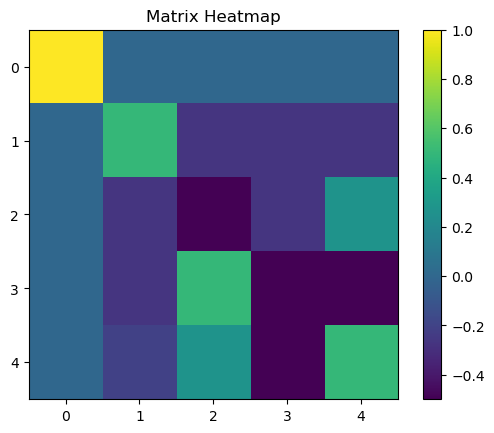

In [23]:
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq



dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1),(2,0)]
fractions = [1,1/2,1]#[np.sin(1)**2]  
rabi_freqs = [1,1,1]      
fixed_phase_flags = [0.5,0.5,0.5]  

dim = 5

init_state = np.array([0,1,0,0,0])
a,b = 1,2
c,d = 3,4
e,f = 2,4
g,h = 1,3
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(0,3),(4,0)]  + [(4,0),(0,2),(4,0)] + [(3,0),(0,1),(3,0)] 
fractions = [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1]
rabi_freqs = [1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)] 
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]

# def fix_couplings_and_phases(couplings, fixed_phase_flags):
#     new_couplings = []
#     new_fixed_phase_flags = []
#     for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
#         i, j = cpl
#         if i != 0 and j == 0:
#             cpl_fixed = (0, i)
#             phase_flag_fixed = phase_flag + 1.0
#         else:
#             cpl_fixed = cpl
#             phase_flag_fixed = phase_flag
#         new_couplings.append(cpl_fixed)
#         new_fixed_phase_flags.append(phase_flag_fixed)
#     return new_couplings, new_fixed_phase_flags
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________')
print(np.round(U1@init_state,3))

import matplotlib.pyplot as plt

plt.imshow(np.real(U1), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()

In [24]:
def build_index_map(strings):
    special_values = {"0", "-2"}
    # Separate special strings (like '0' or '-2') from the rest
    special = [s for s in strings if s in special_values]
    normal = [s for s in strings if s not in special_values]

    # Assign index 0 to all special strings
    index_map = {}
    for s in special:
        index_map[0] = s

    # Assign subsequent indices to normal strings
    current_index = 1
    for s in normal:
        index_map[current_index] = s
        current_index += 1

    return index_map

strings = ['[2, -1]', '[3, -2]', '[4, -4]', '[3, -3]', '-2']
mapping = build_index_map(strings)
print(mapping)


{0: '-2', 1: '[2, -1]', 2: '[3, -2]', 3: '[4, -4]', 4: '[3, -3]'}


In [27]:
def parse_string_to_int_list(s):
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        inside = s[1:-1].strip()
        parts = inside.split(',')
        return [int(x) for x in parts]
    else:
        return [int(s)]

def build_transitions_list(index_to_str_map, couplings):
    transitions_list = []
    for (start_idx, end_idx) in couplings:
        left_list  = parse_string_to_int_list(index_to_str_map[start_idx])
        right_list = parse_string_to_int_list(index_to_str_map[end_idx])
        transitions_list.append(left_list + right_list)
    return transitions_list
print(couplings)
print(build_transitions_list(mapping,couplings))

[(2, 0), (0, 1), (2, 0), (4, 0), (3, 0), (0, 1), (3, 0), (0, 2), (4, 0)]
[[3, -2, -2], [-2, 2, -1], [3, -2, -2], [3, -3, -2], [4, -4, -2], [-2, 2, -1], [4, -4, -2], [-2, 3, -2], [3, -3, -2]]


In [29]:
dim = 9

init_state = np.array([0,1,0,0,0,0,0,0,0])

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(0,3),(4,0)] + [(3,0),(0,1),(3,0)]  + [(4,0),(0,2),(4,0)] + [(6,0),(0,5),(6,0)] + [(8,0),(0,7),(8,0)] + [(7,0),(0,5),(7,0)] + [(8,0),(0,6),(8,0)] \
 + [(5,0),(0,1),(5,0)] + [(6,0),(0,2),(6,0)] + [(7,0),(0,3),(7,0)] + [(8,0),(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] \
 + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1]
rabi_freqs = [1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] \
 + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]


couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings)
U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________',len(couplings))
print(np.round(U1@init_state,1))
plt.imshow(np.real(U1), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()

NameError: name 'fix_couplings_and_phases' is not defined

In [31]:
dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1)]
fractions = [1,1/2]#[np.sin(1)**2]  
rabi_freqs = [1,1]      
fixed_phase_flags = [0.5,0.5]   

# dim =2
# init_state = np.array([1,0])
# couplings = [(0,1)]
# fractions = [1/2]
# rabi_freqs = [1,1]      
# fixed_phase_flags = [0.5,0.5] 

U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________')
print(np.round(U1@init_state,3))

[[-0.   +0.j     0.339-0.621j -0.339-0.621j]
 [ 0.   -0.j     0.707-0.j    -0.382+0.595j]
 [ 0.479-0.878j  0.   +0.j     0.   -0.j   ]]
________________________
[0.339-0.621j 0.707-0.j    0.   +0.j   ]


In [33]:
#####Z - gate:
dim =2 
init_state = np.array([1,0])
couplings = [(0, 1),(0,1),(0,1)]
fractions = [0.5,1,0.5]#[1/2, 1,1/2]
rabi_freqs = [1,1,1]      
fixed_phase_flags = [1,0.5,0]     

#### Hadamard - gate

dim =2 
init_state = np.array([1,0])
couplings = [(0,1),(0,1),(0,1),(0,1)]
fractions = [1/2, 1,1/2,1/2]#[np.sin(1)**2]  
rabi_freqs = [1,1,1,1]      
fixed_phase_flags = [1,0.5,0,1.5]  

###bused hadamard 

dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1),(2,0)]
fractions = [1,1/2,1]#[np.sin(1)**2]  
rabi_freqs = [1,1,1]      
fixed_phase_flags = [0.5,0.5,0.5]   

####bused X-gate

dim =3 #state 1 is the bus
init_state = np.array([1,0,0])
couplings = [(0,1),(1,2),(0,1)]
fractions = [1,1,1]
rabi_freqs = [1,1,1]
fixed_phase_flags = [0,1,0]

### 2 Poly Qubit Hadamard Bussed

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)] 
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]

### 3 poly Qudit hadamard Bussed
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags =  [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   + [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]


In [35]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    This operator acts nontrivially only in the two-dimensional subspace spanned by |i> and |j>.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    """
    Interprets the input 'f' directly as the rotation angle (in radians).
    The pulse duration is then t = angle / Omega.
    """
    theta = f  # Here we interpret f as the desired rotation angle.
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    """
    Constructs a unitary by sequentially applying pulses.
    
    In a 4-level system (encoding 2 qubits):
      - We assume couplings is a list of tuples indicating which levels are coupled.
      - fractions (interpreted as rotation angles) and fixed_phase_flags (multiplied by π)
        set the pulse parameters.
        
    When applied to the initial state |00>, the overall unitary ideally produces an equal 
    superposition over all basis states.
    """
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def bv_oracle(dim, hidden_string):
    """
    Constructs the BV oracle unitary for a system of dimension dim = 2^n.
    
    For each computational basis state |x>, where x is represented as an n-bit binary number,
    the oracle applies a phase:
       (-1)^(s · x)
    where s is the hidden string (given as a string, e.g. "10").
    """
    n = int(np.log2(dim))
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(dim).")
    # Convert hidden_string to a list of bits
    s_bits = [int(bit) for bit in hidden_string]
    oracle = np.eye(dim, dtype=complex)
    for x in range(dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * x_bit for s, x_bit in zip(s_bits, x_bits)) % 2
        if dot == 1:
            oracle[x, x] = -1
    return oracle

def bv_algorithm(hidden_string, U_sup):
    """
    Runs the Bernstein–Vazirani algorithm for a given hidden string.
    
    Steps:
      1. Prepare initial state |0...0>.
      2. Apply the equal-superposition unitary U_sup.
      3. Apply the oracle U_oracle.
      4. Apply U_sup^\dagger (the inverse of U_sup).
      
    Returns the final state.
    """
    dim = U_sup.shape[0]
    init_state = np.zeros(dim, dtype=complex)
    init_state[0] = 1.0  # |00...0>
    
    # Step 1: Create superposition.
    state_super = U_sup @ init_state
    print("State after equal superposition:")
    print(np.round(state_super, 3))
    
    # Step 2: Apply oracle.
    U_oracle = bv_oracle(dim, hidden_string)
    state_oracle = U_oracle @ state_super
    print(f"State after applying BV oracle for hidden string '{hidden_string}':")
    print(np.round(state_oracle, 3))
    
    # Step 3: Apply inverse superposition.
    state_final = U_sup.conj().T @ state_oracle
    print("Final state after applying inverse equal superposition:")
    print(np.round(state_final, 3))
    print("---------------------------------------------------")
    return state_final

def main():
    # Use a 4-level system (2 poly-qubits).
    dim = 5
    couplings = [(0,1), (0,2), (0,3)]
    # The fractions here are chosen as rotation angles.
    fractions = [1/4, 1/3, 1/2]  
    rabi_freqs = [1, 1, 1]
    fixed_phase_flags = [0, 0, 0]
    
    U_sup = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    print("Equal-superposition unitary U_sup:")
    print(np.round(U_sup, 3))
    print("---------------------------------------------------")
    
    # Test the BV algorithm for each possible hidden string.
    hidden_strings = ["00", "01", "10", "11"]
    results = {}
    for hs in hidden_strings:
        print(f"Running BV algorithm for hidden string: {hs}")
        state_final = bv_algorithm(hs, U_sup)
        # For ideal BV, the final state should be |s> (up to global phase)
        # We record the index with maximum probability.
        prob = np.abs(state_final)**2
        measured = np.argmax(prob)
        results[hs] = measured
    print("Measured output indices (in binary) for each hidden string:")
    for hs, idx in results.items():
        print(f"Hidden string {hs} -> Measured state: {format(idx, '02b')}")
    
if __name__ == '__main__':
    main()


Equal-superposition unitary U_sup:
[[ 0.948+0.j     0.   -0.119j  0.   -0.161j  0.   -0.247j  0.   +0.j   ]
 [ 0.   -0.125j  0.992+0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   -0.165j -0.021+0.j     0.986+0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   -0.242j -0.03 +0.j    -0.041+0.j     0.969+0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
---------------------------------------------------
Running BV algorithm for hidden string: 00
State after equal superposition:
[0.948+0.j    0.   -0.125j 0.   -0.165j 0.   -0.242j 0.   +0.j   ]
State after applying BV oracle for hidden string '00':
[0.948+0.j    0.   -0.125j 0.   -0.165j 0.   -0.242j 0.   +0.j   ]
Final state after applying inverse equal superposition:
[1.+0.j 0.+0.j 0.-0.j 0.+0.j 0.+0.j]
---------------------------------------------------
Running BV algorithm for hidden string: 01
State after equal superposition:
[0.948+0.j    0.   -0.125j 0.   -0.165j 0.   -0.242j 0.   +0.

In [37]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    Operates only on the two-dimensional subspace spanned by |i> and |j>.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    """
    Interprets the input 'f' directly as the rotation angle (in radians).
    The pulse duration is then t = angle / Omega.
    """
    theta = f  # Here we treat f as the rotation angle.
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    """
    Constructs a unitary by applying a sequence of pulses.
    This function is assumed to work on a Hilbert space of size 'dim'
    (here, dim will be the computational subspace dimension, i.e. 2^n).
    """
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def embed_operator(U_comp, full_dim, bus_dim):
    """
    Embeds an operator U_comp (acting on the computational subspace)
    into the full Hilbert space.
    
    It assumes that the computational subspace occupies the last (full_dim - bus_dim)
    indices.
    """
    U_full = np.eye(full_dim, dtype=complex)
    U_full[bus_dim:full_dim, bus_dim:full_dim] = U_comp
    return U_full

def bv_oracle(sub_dim, hidden_string):
    """
    Constructs the BV oracle for a computational subspace of dimension sub_dim = 2^n.
    
    For each computational basis state |x> (with x represented as an n-bit number),
    the oracle applies a phase (-1)^(s·x) where s is the hidden bit string.
    """
    n = int(np.log2(sub_dim))
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(sub_dim).")
    s_bits = [int(bit) for bit in hidden_string]
    oracle = np.eye(sub_dim, dtype=complex)
    for x in range(sub_dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * xb for s, xb in zip(s_bits, x_bits)) % 2
        if dot == 1:
            oracle[x, x] = -1
    return oracle

def bv_algorithm(full_dim, U_full, hidden_string, bus_dim, sub_dim):
    """
    Runs the Bernstein–Vazirani algorithm on the full Hilbert space.
    
    The computational subspace (of dimension sub_dim) is assumed to be embedded
    in the full space starting at index 'bus_dim'.
    
    Steps:
      1. Prepare initial state as computational |0> (i.e. at index bus_dim).
      2. Apply U_full (equal superposition on computational subspace).
      3. Apply the embedded oracle.
      4. Apply U_full†.
    """
    # Prepare initial state: bus states are left at 0; the computational |0> is at index bus_dim.
    init_state = np.zeros(full_dim, dtype=complex)
    init_state[bus_dim] = 1.0  
    print("Initial state:")
    print(np.round(init_state, 3))
    
    # Step 1: Apply equal superposition (embedded operator)
    state_super = U_full @ init_state
    print("After equal superposition:")
    print(np.round(state_super, 3))
    
    # Step 2: Apply oracle.
    U_oracle_comp = bv_oracle(sub_dim, hidden_string)
    U_oracle_full = embed_operator(U_oracle_comp, full_dim, bus_dim)
    state_oracle = U_oracle_full @ state_super
    print(f"After applying BV oracle for hidden string '{hidden_string}':")
    print(np.round(state_oracle, 3))
    
    # Step 3: Apply inverse equal superposition.
    state_final = U_full.conj().T @ state_oracle
    print("Final state after inverse superposition:")
    print(np.round(state_final, 3))
    print("---------------------------------------------------")
    return state_final

def get_subsystem_indices(full_dim):
    """
    Determines the computational subspace given the full Hilbert space dimension.
    
    The computational subspace is chosen as the largest power of 2 that is ≤ full_dim.
    The remaining states (if any) are treated as bus states.
    
    Returns:
      bus_dim: number of bus states (the starting index of the computational subspace)
      sub_dim: dimension of the computational subspace (2^n)
    """
    n = int(np.floor(np.log2(full_dim)))
    sub_dim = 2**n
    bus_dim = full_dim - sub_dim
    return bus_dim, sub_dim


full_dim = 5
bus_dim, sub_dim = get_subsystem_indices(full_dim)
print(f"Full dimension: {full_dim}, Bus states: 0 to {bus_dim-1}, Computational subspace (poly qubits) dimension: {sub_dim} (indices {bus_dim} to {full_dim-1})")
print("---------------------------------------------------")

U_full,_,_= polyqubit_hadamard_via_bus(full_dim)
print("Embedded equal-superposition unitary U_full:")
print(np.round(U_full, 3))
print("---------------------------------------------------")

# Loop over all possible hidden strings for the computational subspace.
n = int(np.log2(sub_dim))
hidden_strings = [format(x, f'0{n}b') for x in range(2**n)]

results = {}
for hs in hidden_strings:
    print(f"\nRunning BV algorithm for hidden string: {hs}")
    state_final = bv_algorithm(full_dim, U_full, hs, bus_dim, sub_dim)
    prob = np.abs(state_final)**2
    measured_full = np.argmax(prob)

    if measured_full < bus_dim:
        measured_comp = None
    else:
        measured_comp = measured_full - bus_dim
    results[hs] = measured_comp
print("\nMeasured computational output (0-indexed within the computational subspace) for each hidden string:")
hidden_strings = ["00", "01", "10", "11"]
for hs, idx in results.items():
    print(f"Hidden string {hs} -> Measured computational state: |{hidden_strings[idx]}>")



Full dimension: 5, Bus states: 0 to 0, Computational subspace (poly qubits) dimension: 4 (indices 1 to 4)
---------------------------------------------------


NameError: name 'polyqubit_hadamard_via_bus' is not defined

In [ ]:
import numpy as np

def get_subsystem_indices(full_dim):
    """
    Determines the computational subspace given the full Hilbert space dimension.
    
    We choose the computational subspace as the largest power of 2 that is ≤ full_dim.
    The remaining states (if any) are treated as bus states.
    
    For example:
      - full_dim = 5  -> sub_dim = 4 and bus_dim = 1, so indices 1-4 are used.
      - full_dim = 9  -> sub_dim = 8 and bus_dim = 1, so indices 1-8 are used.
      
    Returns:
      bus_dim: the number of bus states (i.e. the starting index for the computational subspace)
      sub_dim: the dimension of the computational subspace (2^n)
    """
    n = int(np.floor(np.log2(full_dim)))
    sub_dim = 2**n
    bus_dim = full_dim - sub_dim
    return bus_dim, sub_dim

def hadamard_2qubits():
    """
    Constructs the ideal Hadamard on 2 qubits (i.e. a 4x4 unitary).
    """
    H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
    H_2q = np.kron(H_single, H_single)
    return H_2q

def polyqubit_hadamard_via_bus(full_dim):
    
    bus_dim, sub_dim = get_subsystem_indices(full_dim)
    H_2q = hadamard_2qubits()
    
    # Build the full operator as identity on bus states and H_2q on the computational subspace.
    H_full = np.eye(full_dim, dtype=complex)
    H_full[bus_dim:full_dim, bus_dim:full_dim] = H_2q
    return H_full, bus_dim, sub_dim

def main():
    # Choose full Hilbert space dimension.
    # For example, full_dim = 5 means one bus state (index 0) and a 4-dimensional computational subspace (indices 1-4).
    full_dim = 5
    H_full, bus_dim, sub_dim = polyqubit_hadamard_via_bus(full_dim)
    
    print("Full Hilbert space dimension:", full_dim)
    print(f"Bus states: indices 0 to {bus_dim-1} (if any); Computational subspace: indices {bus_dim} to {full_dim-1}")
    print("\nEmbedded Hadamard operator on two poly-qubits (bus left unchanged):")
    print(np.round(H_full, 3))
    
    # Test: prepare the computational |00> state.
    # In our encoding, computational |0> corresponds to the first state of the computational subspace, 
    # which is at index bus_dim in the full space.
    init_state = np.zeros(full_dim, dtype=complex)
    init_state[bus_dim] = 1.0  # |00> in the computational subspace.
    print("\nInitial state (computational |00> embedded):")
    print(np.round(init_state, 3))
    
    out_state = H_full @ init_state
    print("\nOutput state after applying the Hadamard operator:")
    print(np.round(out_state, 3))
    
    # For clarity, show the probabilities in the computational subspace.
    comp_state = out_state[bus_dim:full_dim]
    probs = np.abs(comp_state)**2
    print("\nProbabilities in the computational subspace:")
    print(np.round(probs, 3))
    
    # Note: In an actual experimental sequence, you would decompose H_full into a series of 
    # two-level (Givens) rotations that all couple the bus state (index 0) with the computational states.
    # Here we have directly constructed the ideal embedded operator.
    
if __name__ == '__main__':
    main()


[[ 0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j]
 [ 0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j]
 [ 0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j]
 [ 0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j]
 [ 0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j]
 [ 0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j -0.4+0.j  0.4-0.j]
 [ 0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j  0.4+0.j  0.4+0.j]
 [ 0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j -0.4+0.j  0.4-0.j  0.4+0.j -0.4+0.j]]


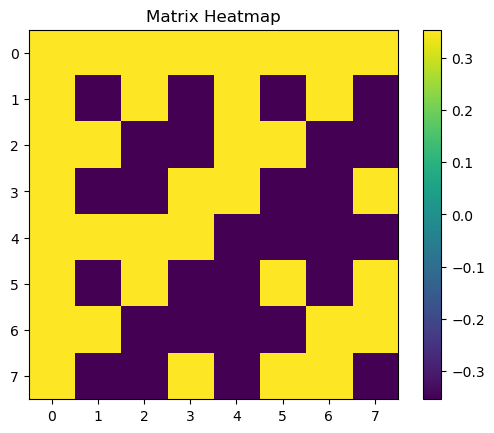

In [40]:

H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
H_3q = np.kron(np.kron(H_single, H_single),H_single)
print(np.round(H_3q,1))

import matplotlib.pyplot as plt

plt.imshow(np.real(H_3q), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()
